In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import BatchNormalization,Flatten,Input,Dense,LeakyReLU,Dropout,Activation,Reshape,Conv2D,Conv2DTranspose

In [26]:
batch_size = 128 
(x_train, y_train), (x_test, y_test) = mnist.load_data()
all_digits=np.concatenate([x_train,x_test])
all_digits=(all_digits.astype("float32")-127.5)/127.5 
all_digits=np.reshape(all_digits,(-1,28,28,1))
dataset=tf.data.Dataset.from_tensor_slices(all_digits)  
dataset=dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)    

In [27]:
#mô hình của mạng Discriminator
discriminator=keras.Sequential(name='Discriminator')
discriminator.add(Input(shape=(28,28,1)))
discriminator.add(Conv2D(filters=64,kernel_size=[5,5],strides=[2,2],padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Conv2D(filters=128,kernel_size=[5,5],strides=[2,2],padding='same'))
discriminator.add(Flatten())
discriminator.add(Dense(units=1))
discriminator.add(Activation(activation='sigmoid',name='sigmoid'))
print(discriminator.summary())

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 flatten_5 (Flatten)         (None, 6272)              0         
                                                                 
 dense_14 (Dense)            (None, 1)                 6273      
                                                                 
 sigmoid (Activation)        (None, 1)                 0         
                                                                 
Total params: 212,865
Trainable params: 212,865
Non-t

In [28]:
#mô hình của mạng Generator
latent_dim=100
generator = keras.Sequential(name='Generator')
generator.add(Input(shape=(latent_dim,)))
generator.add(Dense(units=7*7*256))
generator.add(Reshape(target_shape=(7,7,256)))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(filters=128, kernel_size=[5,5],strides=[1,1],padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(alpha=0.2))
generator.add(Conv2DTranspose(filters=64,kernel_size=[5,5],strides=[2,2],padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(alpha=0.2))
generator.add(Conv2DTranspose(filters=1,kernel_size=[5,5],strides=[2,2],padding='same',activation='tanh'))
generator.add(Reshape(target_shape=(28,28,1)))
print(generator.summary())

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 12544)             1266944   
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 batch_normalization_8 (Batc  (None, 7, 7, 256)        1024      
 hNormalization)                                                 
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 7, 7, 128)        819328    
 ranspose)                                                       
                                                                 
 batch_normalization_9 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                         

In [33]:
class Gan(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(Gan,self).__init__()
        self.discriminator=discriminator 
        self.generator=generator
        self.latent_dim=latent_dim
    def compile(self, d_optimizer, g_optimizer, loss_function):
        super(Gan,self).compile()
        self.d_optimizer=d_optimizer
        self.g_optimizer=g_optimizer
        self.loss_function=loss_function 
    def train_step(self, real_images):
       
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim)) 

        generated_images = self.generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)
 
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
     
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

       
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images) 
            d_loss = self.loss_function(labels, predictions)  
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        ) 

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_function(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [34]:
from IPython.display import Image, display
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=4, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim)) 
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images*127.5+127.5 
        generated_images.numpy() 
        print("epoch ",epoch,end="")
        for i in range(4):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            display(img) 

In [35]:
epochs = 30 
latent_dim =100
gan = Gan(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5), 
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5),
    loss_function=keras.losses.BinaryCrossentropy(),
)

gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=4, latent_dim=latent_dim)],verbose=1)

epoch  0

epoch  1

epoch  2

epoch  3

epoch  4

epoch  5

epoch  6

epoch  7

epoch  8

epoch  9

epoch  10

epoch  11

epoch  12

epoch  13

epoch  14

epoch  15

epoch  16

epoch  17

epoch  18

epoch  19

epoch  20

epoch  21

epoch  22

epoch  23

epoch  24

epoch  25

epoch  26

epoch  27

epoch  28

epoch  29

In [36]:
#sinh ảnh màu
import  matplotlib.pyplot as plt
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=4, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim)) 
        generated_images = self.model.generator(random_latent_vectors) #tạo ảnh
        generated_images.numpy() 
        print("epoch ",epoch,end="")
        fig, axs = plt.subplots(1,4)
        for i in range(4):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            axs[i].imshow(img)

Epoch 1/30
547/547 [==============================] - 39s 68ms/step - d_loss: 0.6651 - g_loss: 0.8536
Epoch 2/30
547/547 [==============================] - 37s 68ms/step - d_loss: 0.6654 - g_loss: 0.8514
Epoch 3/30
547/547 [==============================] - 38s 69ms/step - d_loss: 0.6633 - g_loss: 0.8550
Epoch 4/30
547/547 [==============================] - 37s 69ms/step - d_loss: 0.6643 - g_loss: 0.8601
Epoch 5/30
547/547 [==============================] - 38s 69ms/step - d_loss: 0.6655 - g_loss: 0.8581
Epoch 6/30
547/547 [==============================] - 37s 69ms/step - d_loss: 0.6652 - g_loss: 0.8526
Epoch 7/30
547/547 [==============================] - 38s 69ms/step - d_loss: 0.6650 - g_loss: 0.8533
Epoch 8/30
547/547 [==============================] - 37s 68ms/step - d_loss: 0.6648 - g_loss: 0.8556
Epoch 9/30
547/547 [==============================] - 38s 69ms/step - d_loss: 0.6650 - g_loss: 0.8548
Epoch 10/30
547/547 [==============================] - 37s 69ms/step - d_loss: 0.6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


Epoch 22/30
547/547 [==============================] - 37s 68ms/step - d_loss: 0.6707 - g_loss: 0.8395
Epoch 23/30
547/547 [==============================] - 37s 68ms/step - d_loss: 0.6716 - g_loss: 0.8325
Epoch 24/30
547/547 [==============================] - 37s 68ms/step - d_loss: 0.6727 - g_loss: 0.8336
Epoch 25/30
547/547 [==============================] - 37s 68ms/step - d_loss: 0.6736 - g_loss: 0.8303
Epoch 26/30
547/547 [==============================] - 38s 69ms/step - d_loss: 0.6729 - g_loss: 0.8250
Epoch 27/30
547/547 [==============================] - 37s 68ms/step - d_loss: 0.6745 - g_loss: 0.8288
Epoch 28/30
547/547 [==============================] - 38s 69ms/step - d_loss: 0.6743 - g_loss: 0.8252
Epoch 29/30
547/547 [==============================] - 37s 68ms/step - d_loss: 0.6744 - g_loss: 0.8247
Epoch 30/30
547/547 [==============================] - 38s 69ms/step - d_loss: 0.6751 - g_loss: 0.8224


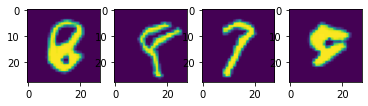

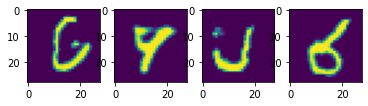

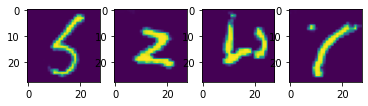

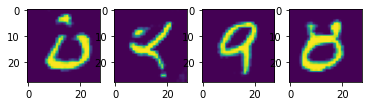

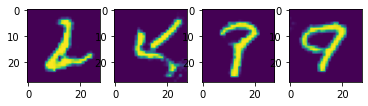

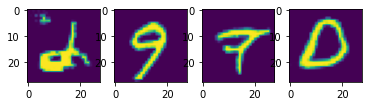

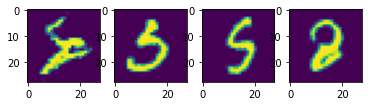

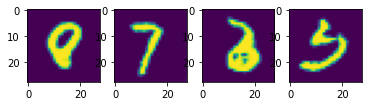

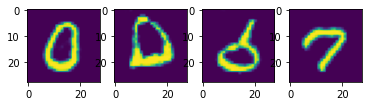

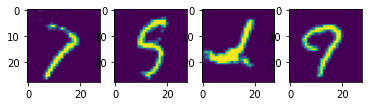

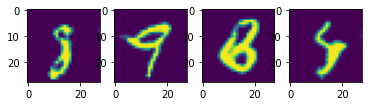

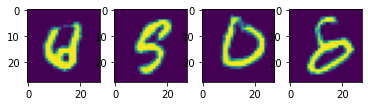

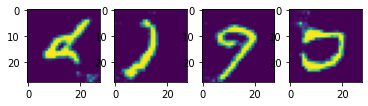

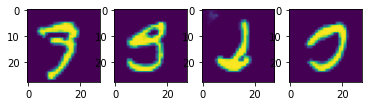

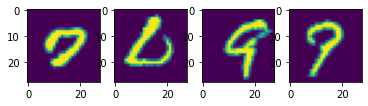

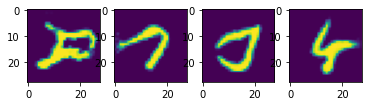

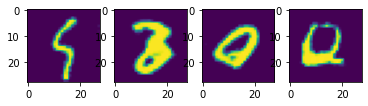

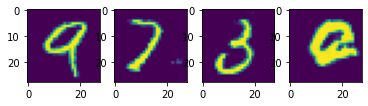

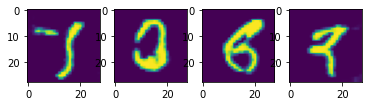

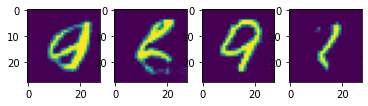

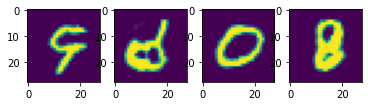

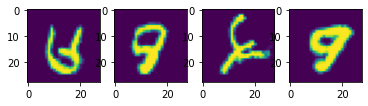

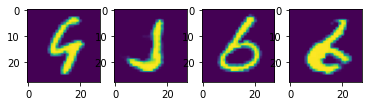

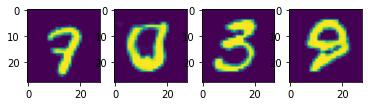

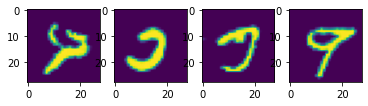

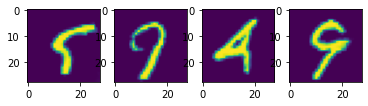

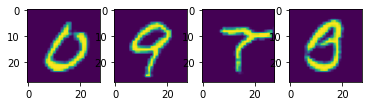

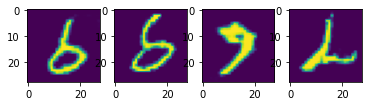

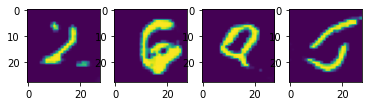

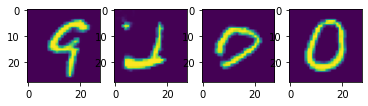

In [37]:
epochs = 30 
latent_dim =100 
gan = Gan(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5), 
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5),
    loss_function=keras.losses.BinaryCrossentropy(),
)
gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=4, latent_dim=latent_dim)],verbose=1)